In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")
import utils as ut

In [3]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
sns.set(font_scale = 2)

In [4]:
# step 1: coverage of all enhancers in input and output
# step 2: RPM normalized coverage in input and output
# step 3: RPP values of all enhancers
# step 4: RPKM normalized expression values of genes
# step 5: scatter plot of RPKM vs RPP values 

In [5]:
rnaseq_rpkm_file = "/data5/deepro/starrseq/main_library/9_rnaseq_comparison/data/meta_counts_norm.csv"
peak_rpp_file = "/data5/deepro/starrseq/main_library/9_rnaseq_comparison/data/meta_rpp.csv"
enhancer_gene_map_dir = "/data5/deepro/starrseq/main_library/8_enhancer_gene_map/data/lib_peak"

libs = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2"]

In [6]:
def get_deltadf(df, lib):
    delsers = []
    for name, group in df.groupby(df.columns.map(lambda x: x.split("_")[1]), axis=1):
        delser = group.loc[:, f"CC_{name}"] - group.loc[:, f"{lib}_{name}"]
        delser.name = name
        delsers.append(delser)
    deldf = pd.concat(delsers, axis=1)
    return deldf.mean(axis=1).to_frame()

def read_and_extract_eg_mappings(filename):
    df = pd.read_csv(filename, skiprows=3, sep="\t")
    df = df.loc[df.iloc[:, 0]=="Ensembl Genes"]
    df.Regions = df.Regions.str.split(",")
    df = df.explode("Regions", ignore_index=True)
    df = df.loc[:, ["Regions", "Genes"]]
    df[["chrm", "start"]] = df.Regions.str.split("-", expand=True)[0].str.split(":", expand=True)
    df["end"] = df.Regions.str.split("-", expand=True)[1]
    df = df.astype({"start": int, "end": int})
    return df.loc[:, ["chrm", "start", "end", "Genes"]]

In [7]:
rpp_thresh = 1
rpkm_thresh = 2

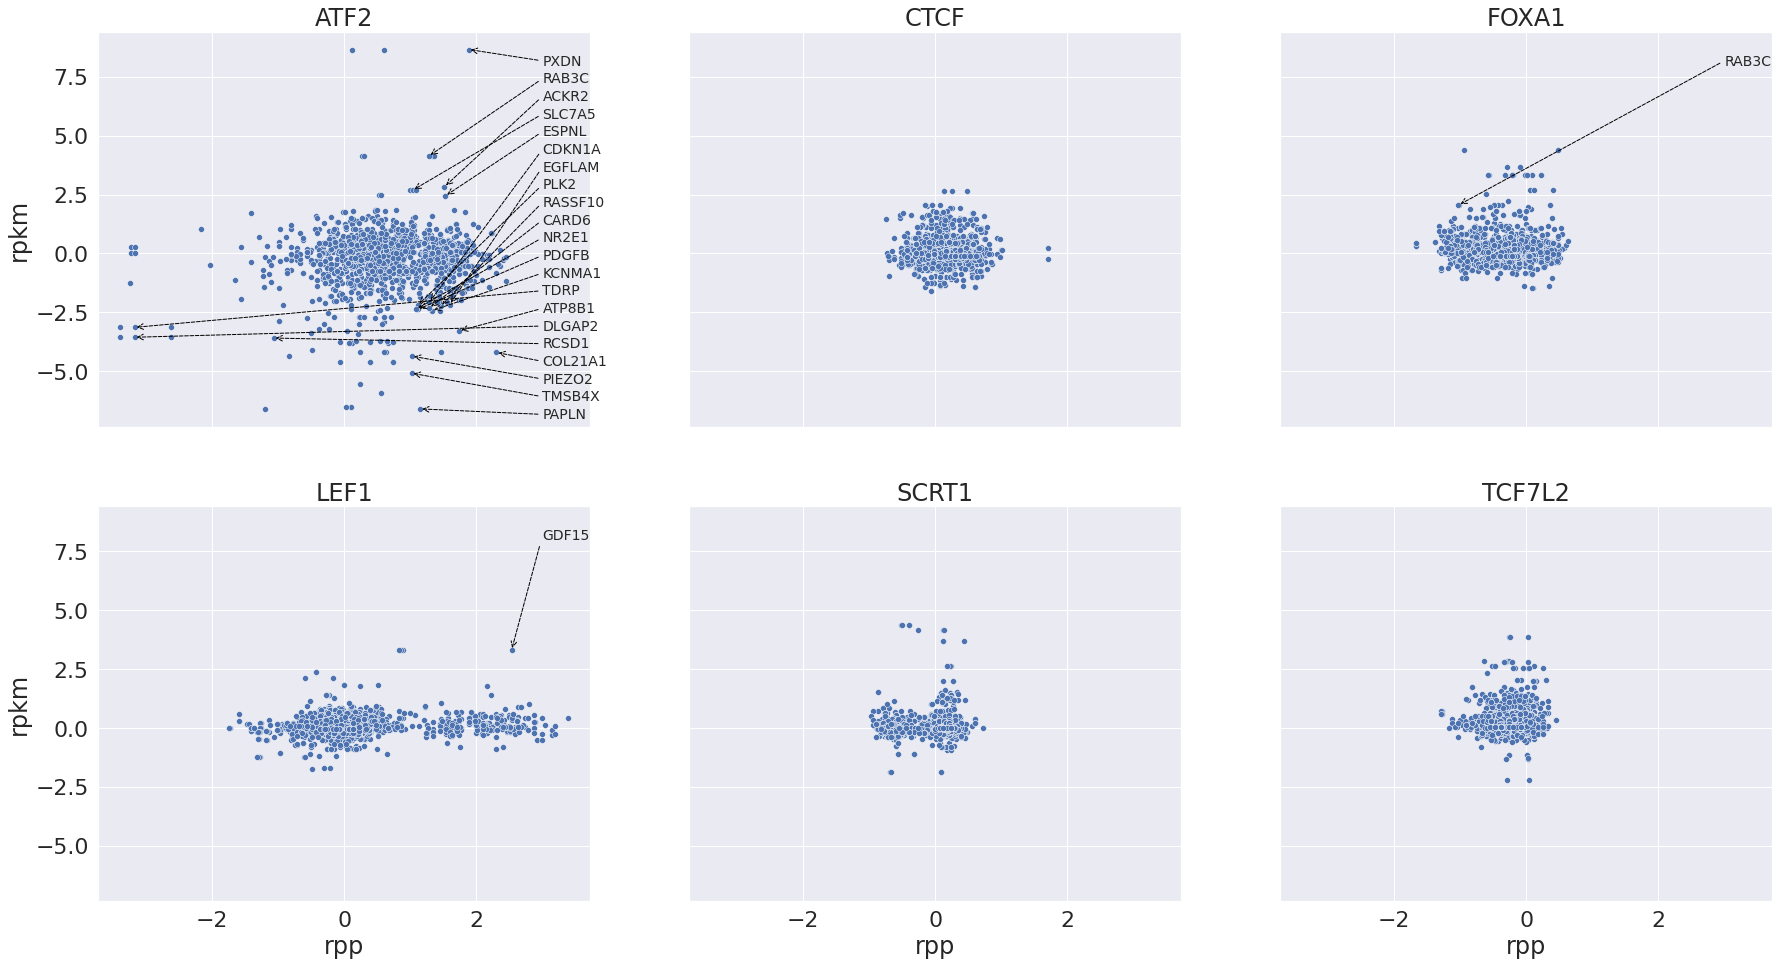

In [8]:
## create the subplot figure
all_lib_names_arr = np.array(libs).reshape(2,3)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,16), sharex=True, sharey=True)


for i in range(2):
    for j in range(3):
        lib = all_lib_names_arr[i, j]
        # delta rpp df
        peak_rpp_df = pd.read_csv(peak_rpp_file, index_col=[0,1,2])
        peak_rpp_lib_df = np.log2(peak_rpp_df.loc[:, [c for c in peak_rpp_df.columns if ((c.startswith(lib)) or (c.startswith("CC")))]])
        delta_rpp_df = get_deltadf(peak_rpp_lib_df, lib)
        delta_rpp_df.index = delta_rpp_df.index.set_names(["chrm", "start", "end"]) 
        # delta rpkm df
        rnaseq_rpkm_df = pd.read_csv(rnaseq_rpkm_file, index_col=[0,1,2])
        rnaseq_rpkm_lib_df = np.log2(rnaseq_rpkm_df.loc[:, [c for c in rnaseq_rpkm_df.columns if ((c.startswith(lib)) or (c.startswith("CC")))]])
        delta_rpkm_df = get_deltadf(rnaseq_rpkm_lib_df, lib)
        # enhancer gene map df
        eg_map_file_cc = os.path.join(enhancer_gene_map_dir, "CC", "great", "peaks.tsv")
        eg_map_file_lib = os.path.join(enhancer_gene_map_dir, lib, "great", "peaks.tsv")
        eg_cc_df = read_and_extract_eg_mappings(eg_map_file_cc)
        eg_lib_df = read_and_extract_eg_mappings(eg_map_file_lib)
        eg_df = pd.concat((eg_cc_df, eg_lib_df)).drop_duplicates().set_index(["chrm", "start", "end"])
        # select only eg genes rpkm values
        genes_rpkm_df = delta_rpkm_df.loc[delta_rpkm_df.index.get_level_values('gene_name').isin(eg_df.Genes)].droplevel([0, 2])
        genes_rpkm_df = genes_rpkm_df.loc[~genes_rpkm_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)].reset_index()
        # select only eg enhancers rpp values
        eg_rpp_df = eg_df.merge(delta_rpp_df, left_index=True, right_index=True).reset_index()
        # create df with both rpkm rpp values
        rpkm_rpp_df = eg_rpp_df.merge(genes_rpkm_df, left_on="Genes", right_on="gene_name")
        rpkm_rpp_df = rpkm_rpp_df.rename(columns={"0_x": "rpp", "0_y": "rpkm"})
        sns_ax = sns.scatterplot(data=rpkm_rpp_df, x="rpp", y="rpkm", palette="deep", legend=False, ax=axes[i][j])
        sns_ax.set_title(f"{lib}")
        rpkm_rpp_selected_df = rpkm_rpp_df.loc[((abs(rpkm_rpp_df.rpp)>rpp_thresh)&(abs(rpkm_rpp_df.rpkm)>rpkm_thresh))]

        gene_set = set()
        y_coord = 8
        for info in rpkm_rpp_selected_df.sort_values(["rpkm"], ascending=False).itertuples():
            if info.Genes not in gene_set:
                axes[i][j].annotate(info.Genes, xy=(info.rpp, info.rpkm), xytext=(3, y_coord), arrowprops={"arrowstyle": "->", "lw": 1, "color": "black", "ls": "--", "relpos": (0,0.5)}, fontsize=14)
                gene_set.add(info.Genes)
                y_coord -= 0.75


In [9]:
rpkm_rpp_df.sort_values(["rpkm"], ascending=False)

,chrm,start,end,Genes,rpp,gene_name,rpkm
288,chr10,112724739,112725239,TCF7L2,-0.261764,TCF7L2,3.870348
289,chr10,113067337,113067837,TCF7L2,0.034493,TCF7L2,3.870348
290,chr10,113073743,113074243,TCF7L2,-0.235223,TCF7L2,3.870348
364,chr11,128421570,128422070,ETS1,-0.251130,ETS1,2.828471
363,chr11,128361361,128361944,ETS1,-0.290311,ETS1,2.828471
...,...,...,...,...,...,...,...
752,chr17,43720357,43720935,MEOX1,-0.299661,MEOX1,-1.301040
751,chr17,43591712,43592250,MEOX1,0.034458,MEOX1,-1.301040
750,chr17,43591712,43592212,MEOX1,0.028099,MEOX1,-1.301040
1291,chr5,76690799,76691299,F2RL2,0.045348,F2RL2,-2.217353
